In [1]:
# Cell 1: Mount Google Drive and set up environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ham_windsurf

/content/drive/MyDrive/ham_windsurf


In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from src.dataloader import get_data_loaders, HAM10000Dataset
from datetime import datetime
import os

import importlib
import src.evaluate
importlib.reload(src.evaluate) # Make sure this line is present and executed
from src.evaluate import evaluate_model

import src.train
importlib.reload(src.train)
from src.train import train_model

from src.models import BasicResNet

In [4]:
"""
# Cell 2: Import the CustomCBAMResNet model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.shared_mlp = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes, bias=False)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x).squeeze(-1).squeeze(-1))
        max_out = self.shared_mlp(self.max_pool(x).squeeze(-1).squeeze(-1))
        out = avg_out + max_out
        return torch.sigmoid(out).unsqueeze(-1).unsqueeze(-1)


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return torch.sigmoid(self.conv(x_cat))


class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


class CustomCBAMResNet(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        self.base = resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)

        # We'll apply attention only to the output of the final conv layer
        self.cbam = CBAM(2048)  # Output of layer4 has 2048 channels

        # Modify classifier head
        self.base.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        # Apply attention to the final feature map
        x = self.cbam(x)

        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base.fc(x)
        return x
"""

"\n# Cell 2: Import the CustomCBAMResNet model\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nfrom torchvision.models import resnet50, ResNet50_Weights\n\n\nclass ChannelAttention(nn.Module):\n    def __init__(self, in_planes, ratio=16):\n        super().__init__()\n        self.shared_mlp = nn.Sequential(\n            nn.Linear(in_planes, in_planes // ratio, bias=False),\n            nn.ReLU(),\n            nn.Linear(in_planes // ratio, in_planes, bias=False)\n        )\n        self.avg_pool = nn.AdaptiveAvgPool2d(1)\n        self.max_pool = nn.AdaptiveMaxPool2d(1)\n\n    def forward(self, x):\n        avg_out = self.shared_mlp(self.avg_pool(x).squeeze(-1).squeeze(-1))\n        max_out = self.shared_mlp(self.max_pool(x).squeeze(-1).squeeze(-1))\n        out = avg_out + max_out\n        return torch.sigmoid(out).unsqueeze(-1).unsqueeze(-1)\n\n\nclass SpatialAttention(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv = nn.Conv2d

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class SEResNet(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super().__init__()
        self.base = resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)

        # Add SE blocks for each ResNet layer stage
        self.se_layer1 = SEModule(256)
        self.se_layer2 = SEModule(512)
        self.se_layer3 = SEModule(1024)
        self.se_layer4 = SEModule(2048)

        # Modify classifier for your class count
        self.base.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Initial layers
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        # Layer 1 with SE block
        x = self.base.layer1(x)
        identity = x
        x = self.se_layer1(x)
        x = x + identity

        # Layer 2 with SE block
        x = self.base.layer2(x)
        identity = x
        x = self.se_layer2(x)
        x = x + identity

        # Layer 3 with SE block
        x = self.base.layer3(x)
        identity = x
        x = self.se_layer3(x)
        x = x + identity

        # Layer 4 with SE block
        x = self.base.layer4(x)
        identity = x
        x = self.se_layer4(x)
        x = x + identity

        # Final layers (classifier)
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base.fc(x)
        return x


In [6]:
# Cell 3 (Updated): Import necessary modules and reload evaluate
import importlib # Add this line
import src.evaluate # Add this line to import the module itself
importlib.reload(src.evaluate) # Reload the module
from src.evaluate import evaluate_model # Re-import the function from the reloaded module

from src.train import train_model
# Import the model we just defined in-notebook (HAMFusionNet)

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [7]:
# Cell 4: Configure paths
# Configure paths
csv_file = '/content/drive/MyDrive/ham_windsurf/archive/GroundTruth_filtered.csv'
img_dir = '/content/drive/MyDrive/ham_windsurf/archive/hair_removed_images'
#mask_dir = 'archive/masks'

# Create output directory for saving results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = f'results/FINAL_SEResnet_ACGAN_200_{timestamp}'
os.makedirs(output_dir, exist_ok=True)

In [8]:
"""
# Cell 5: Set training parameters
# Set training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

# Get data loaders
print("Loading data...")
data_loaders = get_data_loaders(
    csv_file=csv_file,
    img_dir=img_dir,
    #mask_dir=mask_dir,
    batch_size=BATCH_SIZE,
    use_masks=False,
    val_split=0.1,
    test_split=0.1
)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(len(data_loaders['test'].dataset))
print(len(data_loaders['train'].dataset))
print(len(data_loaders['val'].dataset))
"""


# Cell 5 (Modified): Set training parameters and load data with proper splits

# Set paths
csv_file = '/content/drive/MyDrive/ham_windsurf/archive/GroundTruth_filtered.csv'
original_img_dir = '/content/drive/MyDrive/ham_windsurf/archive/hair_removed_images'  # Original images only
augmented_img_dir = '/content/drive/MyDrive/ham_windsurf/archive/acgan_merged'  # Path to folder with all images (original + GAN)
augmented_csv_file = '/content/drive/MyDrive/ham_windsurf/data/train_augmented.csv'

# Set training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

# First, get the standard data loaders to generate the val and test splits
print("Loading data for splits...")
standard_loaders = get_data_loaders(
    csv_file=csv_file,
    img_dir=original_img_dir,  # Use original images directory for validation and test
    batch_size=BATCH_SIZE,
    use_masks=False,
    val_split=0.1,
    test_split=0.1
)

# Now create a new train loader with the augmented data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define the same transforms used in the original loader
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset with the augmented training data
augmented_train_dataset = HAM10000Dataset(
    csv_file=augmented_csv_file,
    img_dir=augmented_img_dir,  # Use the combined directory for training
    transform=train_transform,
    use_masks=False
)

# Create a data loader for the augmented training data
augmented_train_loader = DataLoader(
    augmented_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

# Create the final data loaders dictionary using the augmented train loader
# but keeping the original validation and test loaders
data_loaders = {
    'train': augmented_train_loader,
    'val': standard_loaders['val'],
    'test': standard_loaders['test'],
    'categories': standard_loaders['categories']
}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"Test dataset size: {len(data_loaders['test'].dataset)}")
print(f"Augmented train dataset size: {len(data_loaders['train'].dataset)}")
print(f"Validation dataset size: {len(data_loaders['val'].dataset)}")

Loading data for splits...
Using device: cuda
Test dataset size: 975
Augmented train dataset size: 17748
Validation dataset size: 975


In [9]:
print("Initializing SEResnet model...")

# Initialize the model with 5 classes (based on your memories)
model = SEResNet(num_classes=5, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary for SEResNet:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Initializing SEResnet model...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]



Model Summary for SEResNet:
Total parameters: 25,257,029
Trainable parameters: 25,257,029


In [10]:
NUM_EPOCHS = 150

# Cell 7: Train the model
# Train the model
print("\nStarting training...")
model, training_history = train_model(
    model=model,
    train_loader=data_loaders['train'],
    val_loader=data_loaders['val'],
    device=device,
    num_epochs=NUM_EPOCHS,
    patience=100,
    weight_classes=True,
    save_path=os.path.join(output_dir, 'best_model.pth')
)


Starting training...
train_model: Entered function.
train_model: weight_classes is True. Collecting all training labels for weight calculation...


train_model: Finished collecting 17748 training labels.
train_model: Using class weights: [0.5437788  0.69070077 0.69880915 1.2053014  1.8614099 ]
train_model: Starting training epochs...


Validation: 100%|██████████| 31/31 [04:17<00:00,  8.30s/it]


Epoch 1/150:
Train Loss: 0.4418, Train Acc: 0.8315, Train F1: 0.8270
Val Loss: 0.7435, Val Acc: 0.7518, Val F1: 0.4635
  Class 0 F1: 0.8824
  Class 1 F1: 0.1800
  Class 2 F1: 0.1778
  Class 3 F1: 0.5000
  Class 4 F1: 0.5773


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.89it/s]


Epoch 2/150:
Train Loss: 0.3390, Train Acc: 0.8675, Train F1: 0.8674
Val Loss: 0.6884, Val Acc: 0.7662, Val F1: 0.5793
  Class 0 F1: 0.8901
  Class 1 F1: 0.3390
  Class 2 F1: 0.5396
  Class 3 F1: 0.5755
  Class 4 F1: 0.5524


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.86it/s]


Epoch 3/150:
Train Loss: 0.2962, Train Acc: 0.8797, Train F1: 0.8795
Val Loss: 0.6551, Val Acc: 0.7733, Val F1: 0.5737
  Class 0 F1: 0.8968
  Class 1 F1: 0.3793
  Class 2 F1: 0.5498
  Class 3 F1: 0.5000
  Class 4 F1: 0.5426


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]


Epoch 4/150:
Train Loss: 0.2813, Train Acc: 0.8860, Train F1: 0.8874
Val Loss: 0.7312, Val Acc: 0.7518, Val F1: 0.4880
  Class 0 F1: 0.9076
  Class 1 F1: 0.4085
  Class 2 F1: 0.2041
  Class 3 F1: 0.4880
  Class 4 F1: 0.4318


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.86it/s]


Epoch 5/150:
Train Loss: 0.2984, Train Acc: 0.8827, Train F1: 0.8841
Val Loss: 0.6768, Val Acc: 0.7795, Val F1: 0.5156
  Class 0 F1: 0.8995
  Class 1 F1: 0.1379
  Class 2 F1: 0.4456
  Class 3 F1: 0.5210
  Class 4 F1: 0.5741


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.29it/s]


Epoch 6/150:
Train Loss: 0.2782, Train Acc: 0.8866, Train F1: 0.8877
Val Loss: 0.6522, Val Acc: 0.7703, Val F1: 0.5371
  Class 0 F1: 0.8978
  Class 1 F1: 0.2913
  Class 2 F1: 0.4568
  Class 3 F1: 0.4633
  Class 4 F1: 0.5763


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]


Epoch 7/150:
Train Loss: 0.2657, Train Acc: 0.8905, Train F1: 0.8927
Val Loss: 0.6140, Val Acc: 0.7764, Val F1: 0.5420
  Class 0 F1: 0.9152
  Class 1 F1: 0.4024
  Class 2 F1: 0.2774
  Class 3 F1: 0.5926
  Class 4 F1: 0.5223


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.22it/s]


Epoch 8/150:
Train Loss: 0.2591, Train Acc: 0.8952, Train F1: 0.8974
Val Loss: 0.6651, Val Acc: 0.7846, Val F1: 0.6014
  Class 0 F1: 0.8983
  Class 1 F1: 0.5070
  Class 2 F1: 0.5492
  Class 3 F1: 0.5524
  Class 4 F1: 0.5000


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.88it/s]


Epoch 9/150:
Train Loss: 0.2529, Train Acc: 0.8986, Train F1: 0.9009
Val Loss: 0.5444, Val Acc: 0.8123, Val F1: 0.6401
  Class 0 F1: 0.9103
  Class 1 F1: 0.4380
  Class 2 F1: 0.4699
  Class 3 F1: 0.7049
  Class 4 F1: 0.6777


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.00it/s]


Epoch 10/150:
Train Loss: 0.2527, Train Acc: 0.8987, Train F1: 0.9013
Val Loss: 0.6218, Val Acc: 0.8113, Val F1: 0.5895
  Class 0 F1: 0.9111
  Class 1 F1: 0.2800
  Class 2 F1: 0.6354
  Class 3 F1: 0.6329
  Class 4 F1: 0.4878


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.21it/s]


Epoch 11/150:
Train Loss: 0.2406, Train Acc: 0.9021, Train F1: 0.9033
Val Loss: 0.5381, Val Acc: 0.8287, Val F1: 0.6713
  Class 0 F1: 0.9177
  Class 1 F1: 0.4615
  Class 2 F1: 0.6095
  Class 3 F1: 0.7083
  Class 4 F1: 0.6593


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]


Epoch 12/150:
Train Loss: 0.2315, Train Acc: 0.9031, Train F1: 0.9056
Val Loss: 0.5650, Val Acc: 0.8041, Val F1: 0.6374
  Class 0 F1: 0.9083
  Class 1 F1: 0.5106
  Class 2 F1: 0.4671
  Class 3 F1: 0.7077
  Class 4 F1: 0.5934


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]


Epoch 13/150:
Train Loss: 0.2297, Train Acc: 0.9047, Train F1: 0.9062
Val Loss: 0.5258, Val Acc: 0.8226, Val F1: 0.6439
  Class 0 F1: 0.9187
  Class 1 F1: 0.4060
  Class 2 F1: 0.5918
  Class 3 F1: 0.6591
  Class 4 F1: 0.6441


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.62it/s]


Epoch 14/150:
Train Loss: 0.2323, Train Acc: 0.9035, Train F1: 0.9058
Val Loss: 0.4868, Val Acc: 0.8369, Val F1: 0.6697
  Class 0 F1: 0.9270
  Class 1 F1: 0.4746
  Class 2 F1: 0.5632
  Class 3 F1: 0.6755
  Class 4 F1: 0.7083


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]


Epoch 15/150:
Train Loss: 0.2266, Train Acc: 0.9071, Train F1: 0.9087
Val Loss: 0.5330, Val Acc: 0.8256, Val F1: 0.6528
  Class 0 F1: 0.9140
  Class 1 F1: 0.4194
  Class 2 F1: 0.4845
  Class 3 F1: 0.7442
  Class 4 F1: 0.7021


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.64it/s]


Epoch 16/150:
Train Loss: 0.2228, Train Acc: 0.9114, Train F1: 0.9138
Val Loss: 0.4996, Val Acc: 0.8410, Val F1: 0.6741
  Class 0 F1: 0.9278
  Class 1 F1: 0.4793
  Class 2 F1: 0.5882
  Class 3 F1: 0.6935
  Class 4 F1: 0.6813


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.11it/s]


Epoch 17/150:
Train Loss: 0.2225, Train Acc: 0.9094, Train F1: 0.9119
Val Loss: 0.4799, Val Acc: 0.8308, Val F1: 0.6709
  Class 0 F1: 0.9210
  Class 1 F1: 0.4397
  Class 2 F1: 0.5380
  Class 3 F1: 0.7593
  Class 4 F1: 0.6964


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.71it/s]


Epoch 18/150:
Train Loss: 0.2100, Train Acc: 0.9118, Train F1: 0.9152
Val Loss: 0.4837, Val Acc: 0.8359, Val F1: 0.6568
  Class 0 F1: 0.9285
  Class 1 F1: 0.4286
  Class 2 F1: 0.5889
  Class 3 F1: 0.7097
  Class 4 F1: 0.6281


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]


Epoch 19/150:
Train Loss: 0.2173, Train Acc: 0.9116, Train F1: 0.9141
Val Loss: 0.4486, Val Acc: 0.8472, Val F1: 0.7130
  Class 0 F1: 0.9262
  Class 1 F1: 0.4715
  Class 2 F1: 0.6816
  Class 3 F1: 0.8246
  Class 4 F1: 0.6612


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]


Epoch 20/150:
Train Loss: 0.2219, Train Acc: 0.9102, Train F1: 0.9115
Val Loss: 0.4392, Val Acc: 0.8400, Val F1: 0.7399
  Class 0 F1: 0.9145
  Class 1 F1: 0.5161
  Class 2 F1: 0.7204
  Class 3 F1: 0.7903
  Class 4 F1: 0.7579


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.76it/s]


Epoch 21/150:
Train Loss: 0.2001, Train Acc: 0.9177, Train F1: 0.9207
Val Loss: 0.4605, Val Acc: 0.8544, Val F1: 0.7069
  Class 0 F1: 0.9289
  Class 1 F1: 0.4310
  Class 2 F1: 0.6452
  Class 3 F1: 0.7895
  Class 4 F1: 0.7400


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]


Epoch 22/150:
Train Loss: 0.1999, Train Acc: 0.9175, Train F1: 0.9188
Val Loss: 0.4499, Val Acc: 0.8523, Val F1: 0.7162
  Class 0 F1: 0.9306
  Class 1 F1: 0.5493
  Class 2 F1: 0.6957
  Class 3 F1: 0.7273
  Class 4 F1: 0.6780


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.69it/s]


Epoch 23/150:
Train Loss: 0.2036, Train Acc: 0.9151, Train F1: 0.9185
Val Loss: 0.4101, Val Acc: 0.8554, Val F1: 0.7314
  Class 0 F1: 0.9295
  Class 1 F1: 0.5417
  Class 2 F1: 0.6869
  Class 3 F1: 0.8000
  Class 4 F1: 0.6990


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.81it/s]


Epoch 24/150:
Train Loss: 0.1928, Train Acc: 0.9181, Train F1: 0.9213
Val Loss: 0.4069, Val Acc: 0.8656, Val F1: 0.7326
  Class 0 F1: 0.9358
  Class 1 F1: 0.4746
  Class 2 F1: 0.7136
  Class 3 F1: 0.8099
  Class 4 F1: 0.7292


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.34it/s]


Epoch 25/150:
Train Loss: 0.1944, Train Acc: 0.9202, Train F1: 0.9230
Val Loss: 0.4627, Val Acc: 0.8472, Val F1: 0.6978
  Class 0 F1: 0.9309
  Class 1 F1: 0.5273
  Class 2 F1: 0.6638
  Class 3 F1: 0.7188
  Class 4 F1: 0.6481


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]


Epoch 26/150:
Train Loss: 0.1843, Train Acc: 0.9240, Train F1: 0.9268
Val Loss: 0.3845, Val Acc: 0.8687, Val F1: 0.7579
  Class 0 F1: 0.9361
  Class 1 F1: 0.5775
  Class 2 F1: 0.7421
  Class 3 F1: 0.8235
  Class 4 F1: 0.7103


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.06it/s]


Epoch 27/150:
Train Loss: 0.1826, Train Acc: 0.9222, Train F1: 0.9250
Val Loss: 0.4358, Val Acc: 0.8544, Val F1: 0.7386
  Class 0 F1: 0.9294
  Class 1 F1: 0.6303
  Class 2 F1: 0.6417
  Class 3 F1: 0.7101
  Class 4 F1: 0.7816


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]


Epoch 28/150:
Train Loss: 0.1815, Train Acc: 0.9246, Train F1: 0.9273
Val Loss: 0.3891, Val Acc: 0.8626, Val F1: 0.7259
  Class 0 F1: 0.9370
  Class 1 F1: 0.5289
  Class 2 F1: 0.7220
  Class 3 F1: 0.7692
  Class 4 F1: 0.6726


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.16it/s]


Epoch 29/150:
Train Loss: 0.1729, Train Acc: 0.9270, Train F1: 0.9302
Val Loss: 0.3831, Val Acc: 0.8790, Val F1: 0.7569
  Class 0 F1: 0.9453
  Class 1 F1: 0.5806
  Class 2 F1: 0.7464
  Class 3 F1: 0.7833
  Class 4 F1: 0.7290


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]


Epoch 30/150:
Train Loss: 0.1745, Train Acc: 0.9283, Train F1: 0.9307
Val Loss: 0.3728, Val Acc: 0.8790, Val F1: 0.7720
  Class 0 F1: 0.9425
  Class 1 F1: 0.6241
  Class 2 F1: 0.7115
  Class 3 F1: 0.8319
  Class 4 F1: 0.7500


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]


Epoch 31/150:
Train Loss: 0.1688, Train Acc: 0.9299, Train F1: 0.9334
Val Loss: 0.3775, Val Acc: 0.8728, Val F1: 0.7577
  Class 0 F1: 0.9430
  Class 1 F1: 0.5769
  Class 2 F1: 0.6519
  Class 3 F1: 0.8475
  Class 4 F1: 0.7692


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.92it/s]


Epoch 32/150:
Train Loss: 0.1632, Train Acc: 0.9295, Train F1: 0.9331
Val Loss: 0.3270, Val Acc: 0.8892, Val F1: 0.7993
  Class 0 F1: 0.9416
  Class 1 F1: 0.5891
  Class 2 F1: 0.7822
  Class 3 F1: 0.8952
  Class 4 F1: 0.7885


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.08it/s]


Epoch 33/150:
Train Loss: 0.1591, Train Acc: 0.9324, Train F1: 0.9363
Val Loss: 0.3570, Val Acc: 0.8769, Val F1: 0.7600
  Class 0 F1: 0.9436
  Class 1 F1: 0.5674
  Class 2 F1: 0.7196
  Class 3 F1: 0.7903
  Class 4 F1: 0.7789


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.12it/s]


Epoch 34/150:
Train Loss: 0.1573, Train Acc: 0.9320, Train F1: 0.9354
Val Loss: 0.4042, Val Acc: 0.8574, Val F1: 0.7446
  Class 0 F1: 0.9311
  Class 1 F1: 0.5882
  Class 2 F1: 0.7624
  Class 3 F1: 0.7473
  Class 4 F1: 0.6942


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.13it/s]


Epoch 35/150:
Train Loss: 0.1555, Train Acc: 0.9328, Train F1: 0.9363
Val Loss: 0.3556, Val Acc: 0.8708, Val F1: 0.7504
  Class 0 F1: 0.9372
  Class 1 F1: 0.5373
  Class 2 F1: 0.7560
  Class 3 F1: 0.8000
  Class 4 F1: 0.7216


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.78it/s]


Epoch 36/150:
Train Loss: 0.1559, Train Acc: 0.9316, Train F1: 0.9358
Val Loss: 0.3528, Val Acc: 0.8872, Val F1: 0.7737
  Class 0 F1: 0.9496
  Class 1 F1: 0.6154
  Class 2 F1: 0.7128
  Class 3 F1: 0.8547
  Class 4 F1: 0.7358


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.99it/s]


Epoch 37/150:
Train Loss: 0.1494, Train Acc: 0.9365, Train F1: 0.9406
Val Loss: 0.3014, Val Acc: 0.8923, Val F1: 0.8075
  Class 0 F1: 0.9458
  Class 1 F1: 0.6667
  Class 2 F1: 0.7830
  Class 3 F1: 0.8829
  Class 4 F1: 0.7593


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]


Epoch 38/150:
Train Loss: 0.1520, Train Acc: 0.9355, Train F1: 0.9388
Val Loss: 0.3269, Val Acc: 0.8841, Val F1: 0.7858
  Class 0 F1: 0.9407
  Class 1 F1: 0.6418
  Class 2 F1: 0.7282
  Class 3 F1: 0.8455
  Class 4 F1: 0.7727


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]


Epoch 39/150:
Train Loss: 0.1405, Train Acc: 0.9379, Train F1: 0.9426
Val Loss: 0.3419, Val Acc: 0.8862, Val F1: 0.7951
  Class 0 F1: 0.9488
  Class 1 F1: 0.6069
  Class 2 F1: 0.7347
  Class 3 F1: 0.8496
  Class 4 F1: 0.8354


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.13it/s]


Epoch 40/150:
Train Loss: 0.1434, Train Acc: 0.9397, Train F1: 0.9432
Val Loss: 0.3046, Val Acc: 0.9046, Val F1: 0.8308
  Class 0 F1: 0.9548
  Class 1 F1: 0.7195
  Class 2 F1: 0.7353
  Class 3 F1: 0.9091
  Class 4 F1: 0.8354


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.77it/s]


Epoch 41/150:
Train Loss: 0.1340, Train Acc: 0.9428, Train F1: 0.9465
Val Loss: 0.3033, Val Acc: 0.8964, Val F1: 0.8141
  Class 0 F1: 0.9497
  Class 1 F1: 0.7324
  Class 2 F1: 0.7393
  Class 3 F1: 0.9074
  Class 4 F1: 0.7414


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.26it/s]


Epoch 42/150:
Train Loss: 0.1399, Train Acc: 0.9393, Train F1: 0.9436
Val Loss: 0.3044, Val Acc: 0.9087, Val F1: 0.8331
  Class 0 F1: 0.9582
  Class 1 F1: 0.7310
  Class 2 F1: 0.7644
  Class 3 F1: 0.8485
  Class 4 F1: 0.8632


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]


Epoch 43/150:
Train Loss: 0.1318, Train Acc: 0.9415, Train F1: 0.9455
Val Loss: 0.2965, Val Acc: 0.8995, Val F1: 0.8202
  Class 0 F1: 0.9503
  Class 1 F1: 0.7108
  Class 2 F1: 0.8128
  Class 3 F1: 0.8348
  Class 4 F1: 0.7921


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]


Epoch 44/150:
Train Loss: 0.1248, Train Acc: 0.9465, Train F1: 0.9513
Val Loss: 0.3279, Val Acc: 0.8944, Val F1: 0.8034
  Class 0 F1: 0.9516
  Class 1 F1: 0.7168
  Class 2 F1: 0.7320
  Class 3 F1: 0.8039
  Class 4 F1: 0.8125


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.88it/s]


Epoch 45/150:
Train Loss: 0.1278, Train Acc: 0.9455, Train F1: 0.9499
Val Loss: 0.3407, Val Acc: 0.8995, Val F1: 0.8048
  Class 0 F1: 0.9531
  Class 1 F1: 0.6857
  Class 2 F1: 0.7535
  Class 3 F1: 0.8624
  Class 4 F1: 0.7692


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.07it/s]


Epoch 46/150:
Train Loss: 0.1195, Train Acc: 0.9473, Train F1: 0.9511
Val Loss: 0.2361, Val Acc: 0.9149, Val F1: 0.8508
  Class 0 F1: 0.9598
  Class 1 F1: 0.7349
  Class 2 F1: 0.7981
  Class 3 F1: 0.9159
  Class 4 F1: 0.8454


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]


Epoch 47/150:
Train Loss: 0.1152, Train Acc: 0.9489, Train F1: 0.9541
Val Loss: 0.2916, Val Acc: 0.9138, Val F1: 0.8456
  Class 0 F1: 0.9557
  Class 1 F1: 0.7347
  Class 2 F1: 0.8000
  Class 3 F1: 0.8772
  Class 4 F1: 0.8605


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.01it/s]


Epoch 48/150:
Train Loss: 0.1155, Train Acc: 0.9498, Train F1: 0.9543
Val Loss: 0.2601, Val Acc: 0.9138, Val F1: 0.8477
  Class 0 F1: 0.9588
  Class 1 F1: 0.6968
  Class 2 F1: 0.8018
  Class 3 F1: 0.8972
  Class 4 F1: 0.8837


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.05it/s]


Epoch 49/150:
Train Loss: 0.1136, Train Acc: 0.9518, Train F1: 0.9564
Val Loss: 0.2898, Val Acc: 0.8882, Val F1: 0.8069
  Class 0 F1: 0.9457
  Class 1 F1: 0.6885
  Class 2 F1: 0.7662
  Class 3 F1: 0.8972
  Class 4 F1: 0.7368


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.55it/s]


Epoch 50/150:
Train Loss: 0.1096, Train Acc: 0.9521, Train F1: 0.9562
Val Loss: 0.2787, Val Acc: 0.9026, Val F1: 0.8359
  Class 0 F1: 0.9501
  Class 1 F1: 0.7123
  Class 2 F1: 0.7660
  Class 3 F1: 0.9346
  Class 4 F1: 0.8163


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.10it/s]


Epoch 51/150:
Train Loss: 0.1074, Train Acc: 0.9526, Train F1: 0.9562
Val Loss: 0.2719, Val Acc: 0.9067, Val F1: 0.8316
  Class 0 F1: 0.9551
  Class 1 F1: 0.7020
  Class 2 F1: 0.7931
  Class 3 F1: 0.8571
  Class 4 F1: 0.8506


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.22it/s]


Epoch 52/150:
Train Loss: 0.1157, Train Acc: 0.9495, Train F1: 0.9532
Val Loss: 0.2654, Val Acc: 0.9210, Val F1: 0.8538
  Class 0 F1: 0.9635
  Class 1 F1: 0.7763
  Class 2 F1: 0.8165
  Class 3 F1: 0.8972
  Class 4 F1: 0.8155


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]


Epoch 53/150:
Train Loss: 0.1006, Train Acc: 0.9550, Train F1: 0.9599
Val Loss: 0.2510, Val Acc: 0.9159, Val F1: 0.8536
  Class 0 F1: 0.9584
  Class 1 F1: 0.7805
  Class 2 F1: 0.7926
  Class 3 F1: 0.8793
  Class 4 F1: 0.8571


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.79it/s]


Epoch 54/150:
Train Loss: 0.1035, Train Acc: 0.9550, Train F1: 0.9589
Val Loss: 0.2521, Val Acc: 0.9128, Val F1: 0.8649
  Class 0 F1: 0.9511
  Class 1 F1: 0.7326
  Class 2 F1: 0.8326
  Class 3 F1: 0.8644
  Class 4 F1: 0.9438


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]


Epoch 55/150:
Train Loss: 0.1069, Train Acc: 0.9540, Train F1: 0.9575
Val Loss: 0.3065, Val Acc: 0.9097, Val F1: 0.8281
  Class 0 F1: 0.9595
  Class 1 F1: 0.6993
  Class 2 F1: 0.8000
  Class 3 F1: 0.8544
  Class 4 F1: 0.8276


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.09it/s]


Epoch 56/150:
Train Loss: 0.0999, Train Acc: 0.9561, Train F1: 0.9602
Val Loss: 0.2417, Val Acc: 0.9179, Val F1: 0.8529
  Class 0 F1: 0.9588
  Class 1 F1: 0.7891
  Class 2 F1: 0.7962
  Class 3 F1: 0.8571
  Class 4 F1: 0.8632


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.05it/s]


Epoch 57/150:
Train Loss: 0.0892, Train Acc: 0.9602, Train F1: 0.9641
Val Loss: 0.2373, Val Acc: 0.9303, Val F1: 0.8810
  Class 0 F1: 0.9643
  Class 1 F1: 0.7843
  Class 2 F1: 0.8482
  Class 3 F1: 0.8814
  Class 4 F1: 0.9268


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.94it/s]


Epoch 58/150:
Train Loss: 0.0919, Train Acc: 0.9604, Train F1: 0.9644
Val Loss: 0.2419, Val Acc: 0.9313, Val F1: 0.8814
  Class 0 F1: 0.9657
  Class 1 F1: 0.7547
  Class 2 F1: 0.8649
  Class 3 F1: 0.9043
  Class 4 F1: 0.9176


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.76it/s]


Epoch 59/150:
Train Loss: 0.0936, Train Acc: 0.9595, Train F1: 0.9633
Val Loss: 0.2043, Val Acc: 0.9354, Val F1: 0.8859
  Class 0 F1: 0.9675
  Class 1 F1: 0.8205
  Class 2 F1: 0.8421
  Class 3 F1: 0.9107
  Class 4 F1: 0.8889


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]


Epoch 60/150:
Train Loss: 0.0828, Train Acc: 0.9642, Train F1: 0.9681
Val Loss: 0.1702, Val Acc: 0.9467, Val F1: 0.9164
  Class 0 F1: 0.9711
  Class 1 F1: 0.8333
  Class 2 F1: 0.8624
  Class 3 F1: 0.9630
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.03it/s]


Epoch 61/150:
Train Loss: 0.0841, Train Acc: 0.9630, Train F1: 0.9666
Val Loss: 0.2050, Val Acc: 0.9159, Val F1: 0.8595
  Class 0 F1: 0.9572
  Class 1 F1: 0.7831
  Class 2 F1: 0.8193
  Class 3 F1: 0.8991
  Class 4 F1: 0.8387


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.73it/s]


Epoch 62/150:
Train Loss: 0.0777, Train Acc: 0.9656, Train F1: 0.9695
Val Loss: 0.2023, Val Acc: 0.9477, Val F1: 0.9063
  Class 0 F1: 0.9747
  Class 1 F1: 0.8344
  Class 2 F1: 0.8761
  Class 3 F1: 0.9524
  Class 4 F1: 0.8941


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.74it/s]


Epoch 63/150:
Train Loss: 0.0870, Train Acc: 0.9634, Train F1: 0.9680
Val Loss: 0.1795, Val Acc: 0.9374, Val F1: 0.8931
  Class 0 F1: 0.9677
  Class 1 F1: 0.7879
  Class 2 F1: 0.8850
  Class 3 F1: 0.9159
  Class 4 F1: 0.9091


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.39it/s]


Epoch 64/150:
Train Loss: 0.0818, Train Acc: 0.9648, Train F1: 0.9682
Val Loss: 0.2579, Val Acc: 0.9323, Val F1: 0.8835
  Class 0 F1: 0.9644
  Class 1 F1: 0.8056
  Class 2 F1: 0.8487
  Class 3 F1: 0.9293
  Class 4 F1: 0.8696


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.89it/s]


Epoch 65/150:
Train Loss: 0.0800, Train Acc: 0.9642, Train F1: 0.9679
Val Loss: 0.1891, Val Acc: 0.9477, Val F1: 0.9155
  Class 0 F1: 0.9715
  Class 1 F1: 0.8293
  Class 2 F1: 0.8978
  Class 3 F1: 0.9245
  Class 4 F1: 0.9545


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.82it/s]


Epoch 66/150:
Train Loss: 0.0767, Train Acc: 0.9664, Train F1: 0.9701
Val Loss: 0.1802, Val Acc: 0.9385, Val F1: 0.9066
  Class 0 F1: 0.9652
  Class 1 F1: 0.8068
  Class 2 F1: 0.8772
  Class 3 F1: 0.9623
  Class 4 F1: 0.9213


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.69it/s]


Epoch 67/150:
Train Loss: 0.0751, Train Acc: 0.9666, Train F1: 0.9698
Val Loss: 0.2068, Val Acc: 0.9364, Val F1: 0.8868
  Class 0 F1: 0.9697
  Class 1 F1: 0.8125
  Class 2 F1: 0.8609
  Class 3 F1: 0.9541
  Class 4 F1: 0.8367


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.91it/s]


Epoch 68/150:
Train Loss: 0.0733, Train Acc: 0.9678, Train F1: 0.9712
Val Loss: 0.2383, Val Acc: 0.9292, Val F1: 0.8955
  Class 0 F1: 0.9592
  Class 1 F1: 0.8280
  Class 2 F1: 0.8300
  Class 3 F1: 0.9533
  Class 4 F1: 0.9070


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.76it/s]


Epoch 69/150:
Train Loss: 0.0716, Train Acc: 0.9692, Train F1: 0.9724
Val Loss: 0.2785, Val Acc: 0.9138, Val F1: 0.8591
  Class 0 F1: 0.9574
  Class 1 F1: 0.7487
  Class 2 F1: 0.8219
  Class 3 F1: 0.8952
  Class 4 F1: 0.8723


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]


Epoch 70/150:
Train Loss: 0.0753, Train Acc: 0.9671, Train F1: 0.9700
Val Loss: 0.1783, Val Acc: 0.9559, Val F1: 0.9231
  Class 0 F1: 0.9767
  Class 1 F1: 0.8662
  Class 2 F1: 0.9091
  Class 3 F1: 0.9541
  Class 4 F1: 0.9091


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]


Epoch 71/150:
Train Loss: 0.0693, Train Acc: 0.9712, Train F1: 0.9745
Val Loss: 0.1413, Val Acc: 0.9590, Val F1: 0.9262
  Class 0 F1: 0.9819
  Class 1 F1: 0.8645
  Class 2 F1: 0.8909
  Class 3 F1: 0.9808
  Class 4 F1: 0.9130


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.22it/s]


Epoch 72/150:
Train Loss: 0.0620, Train Acc: 0.9736, Train F1: 0.9767
Val Loss: 0.1767, Val Acc: 0.9415, Val F1: 0.8934
  Class 0 F1: 0.9717
  Class 1 F1: 0.8105
  Class 2 F1: 0.8756
  Class 3 F1: 0.9204
  Class 4 F1: 0.8889


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.19it/s]


Epoch 73/150:
Train Loss: 0.0661, Train Acc: 0.9722, Train F1: 0.9755
Val Loss: 0.1708, Val Acc: 0.9508, Val F1: 0.9184
  Class 0 F1: 0.9760
  Class 1 F1: 0.8312
  Class 2 F1: 0.8783
  Class 3 F1: 0.9541
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.11it/s]


Epoch 74/150:
Train Loss: 0.0653, Train Acc: 0.9721, Train F1: 0.9748
Val Loss: 0.1746, Val Acc: 0.9446, Val F1: 0.9096
  Class 0 F1: 0.9713
  Class 1 F1: 0.8447
  Class 2 F1: 0.8707
  Class 3 F1: 0.9174
  Class 4 F1: 0.9438


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.85it/s]


Epoch 75/150:
Train Loss: 0.0588, Train Acc: 0.9749, Train F1: 0.9777
Val Loss: 0.1605, Val Acc: 0.9385, Val F1: 0.9089
  Class 0 F1: 0.9652
  Class 1 F1: 0.7935
  Class 2 F1: 0.8869
  Class 3 F1: 0.9434
  Class 4 F1: 0.9556


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.06it/s]


Epoch 76/150:
Train Loss: 0.0612, Train Acc: 0.9742, Train F1: 0.9770
Val Loss: 0.2075, Val Acc: 0.9426, Val F1: 0.8991
  Class 0 F1: 0.9730
  Class 1 F1: 0.8503
  Class 2 F1: 0.8451
  Class 3 F1: 0.9259
  Class 4 F1: 0.9011


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.86it/s]


Epoch 77/150:
Train Loss: 0.0593, Train Acc: 0.9755, Train F1: 0.9779
Val Loss: 0.1427, Val Acc: 0.9477, Val F1: 0.9211
  Class 0 F1: 0.9711
  Class 1 F1: 0.8383
  Class 2 F1: 0.8851
  Class 3 F1: 0.9444
  Class 4 F1: 0.9663


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.19it/s]


Epoch 78/150:
Train Loss: 0.0570, Train Acc: 0.9759, Train F1: 0.9783
Val Loss: 0.1955, Val Acc: 0.9549, Val F1: 0.9200
  Class 0 F1: 0.9789
  Class 1 F1: 0.8675
  Class 2 F1: 0.8899
  Class 3 F1: 0.9369
  Class 4 F1: 0.9268


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.65it/s]


Epoch 79/150:
Train Loss: 0.0576, Train Acc: 0.9749, Train F1: 0.9772
Val Loss: 0.1679, Val Acc: 0.9569, Val F1: 0.9281
  Class 0 F1: 0.9789
  Class 1 F1: 0.8659
  Class 2 F1: 0.8959
  Class 3 F1: 0.9358
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.09it/s]


Epoch 80/150:
Train Loss: 0.0507, Train Acc: 0.9777, Train F1: 0.9803
Val Loss: 0.1926, Val Acc: 0.9579, Val F1: 0.9244
  Class 0 F1: 0.9811
  Class 1 F1: 0.8974
  Class 2 F1: 0.8811
  Class 3 F1: 0.9358
  Class 4 F1: 0.9268


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.82it/s]


Epoch 81/150:
Train Loss: 0.0479, Train Acc: 0.9794, Train F1: 0.9825
Val Loss: 0.1890, Val Acc: 0.9549, Val F1: 0.9205
  Class 0 F1: 0.9796
  Class 1 F1: 0.8554
  Class 2 F1: 0.8930
  Class 3 F1: 0.9091
  Class 4 F1: 0.9655


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.83it/s]


Epoch 82/150:
Train Loss: 0.0544, Train Acc: 0.9767, Train F1: 0.9789
Val Loss: 0.1834, Val Acc: 0.9600, Val F1: 0.9287
  Class 0 F1: 0.9825
  Class 1 F1: 0.8875
  Class 2 F1: 0.8899
  Class 3 F1: 0.9423
  Class 4 F1: 0.9412


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.87it/s]


Epoch 83/150:
Train Loss: 0.0470, Train Acc: 0.9795, Train F1: 0.9820
Val Loss: 0.2273, Val Acc: 0.9538, Val F1: 0.9258
  Class 0 F1: 0.9758
  Class 1 F1: 0.8750
  Class 2 F1: 0.8898
  Class 3 F1: 0.9245
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.89it/s]


Epoch 84/150:
Train Loss: 0.0515, Train Acc: 0.9785, Train F1: 0.9806
Val Loss: 0.1849, Val Acc: 0.9518, Val F1: 0.9222
  Class 0 F1: 0.9734
  Class 1 F1: 0.8421
  Class 2 F1: 0.9145
  Class 3 F1: 0.9541
  Class 4 F1: 0.9268


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.39it/s]


Epoch 85/150:
Train Loss: 0.0522, Train Acc: 0.9785, Train F1: 0.9814
Val Loss: 0.1975, Val Acc: 0.9662, Val F1: 0.9344
  Class 0 F1: 0.9854
  Class 1 F1: 0.9000
  Class 2 F1: 0.9211
  Class 3 F1: 0.9630
  Class 4 F1: 0.9024


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]


Epoch 86/150:
Train Loss: 0.0526, Train Acc: 0.9772, Train F1: 0.9793
Val Loss: 0.2096, Val Acc: 0.9590, Val F1: 0.9219
  Class 0 F1: 0.9818
  Class 1 F1: 0.9125
  Class 2 F1: 0.8938
  Class 3 F1: 0.9189
  Class 4 F1: 0.9024


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.90it/s]


Epoch 87/150:
Train Loss: 0.0466, Train Acc: 0.9816, Train F1: 0.9834
Val Loss: 0.2266, Val Acc: 0.9518, Val F1: 0.9102
  Class 0 F1: 0.9780
  Class 1 F1: 0.8554
  Class 2 F1: 0.9013
  Class 3 F1: 0.9245
  Class 4 F1: 0.8916


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]


Epoch 88/150:
Train Loss: 0.0452, Train Acc: 0.9815, Train F1: 0.9832
Val Loss: 0.2112, Val Acc: 0.9549, Val F1: 0.9158
  Class 0 F1: 0.9790
  Class 1 F1: 0.8742
  Class 2 F1: 0.8938
  Class 3 F1: 0.9273
  Class 4 F1: 0.9048


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.03it/s]


Epoch 89/150:
Train Loss: 0.0508, Train Acc: 0.9793, Train F1: 0.9815
Val Loss: 0.2118, Val Acc: 0.9559, Val F1: 0.9259
  Class 0 F1: 0.9786
  Class 1 F1: 0.8690
  Class 2 F1: 0.8992
  Class 3 F1: 0.9444
  Class 4 F1: 0.9383


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.79it/s]


Epoch 90/150:
Train Loss: 0.0499, Train Acc: 0.9810, Train F1: 0.9825
Val Loss: 0.2133, Val Acc: 0.9528, Val F1: 0.9158
  Class 0 F1: 0.9766
  Class 1 F1: 0.8800
  Class 2 F1: 0.8908
  Class 3 F1: 0.9286
  Class 4 F1: 0.9032


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.00it/s]


Epoch 91/150:
Train Loss: 0.0413, Train Acc: 0.9821, Train F1: 0.9843
Val Loss: 0.2534, Val Acc: 0.9579, Val F1: 0.9179
  Class 0 F1: 0.9826
  Class 1 F1: 0.8903
  Class 2 F1: 0.8929
  Class 3 F1: 0.9123
  Class 4 F1: 0.9114


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.31it/s]


Epoch 92/150:
Train Loss: 0.0483, Train Acc: 0.9799, Train F1: 0.9818
Val Loss: 0.2102, Val Acc: 0.9621, Val F1: 0.9335
  Class 0 F1: 0.9811
  Class 1 F1: 0.8831
  Class 2 F1: 0.9163
  Class 3 F1: 0.9358
  Class 4 F1: 0.9512


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]


Epoch 93/150:
Train Loss: 0.0467, Train Acc: 0.9807, Train F1: 0.9828
Val Loss: 0.2215, Val Acc: 0.9528, Val F1: 0.9175
  Class 0 F1: 0.9750
  Class 1 F1: 0.8571
  Class 2 F1: 0.9217
  Class 3 F1: 0.9245
  Class 4 F1: 0.9091


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.16it/s]


Epoch 94/150:
Train Loss: 0.0376, Train Acc: 0.9836, Train F1: 0.9859
Val Loss: 0.2794, Val Acc: 0.9497, Val F1: 0.9172
  Class 0 F1: 0.9736
  Class 1 F1: 0.8519
  Class 2 F1: 0.8860
  Class 3 F1: 0.9444
  Class 4 F1: 0.9302


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]


Epoch 95/150:
Train Loss: 0.0417, Train Acc: 0.9829, Train F1: 0.9842
Val Loss: 0.1974, Val Acc: 0.9549, Val F1: 0.9183
  Class 0 F1: 0.9782
  Class 1 F1: 0.8790
  Class 2 F1: 0.8959
  Class 3 F1: 0.9189
  Class 4 F1: 0.9195


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.77it/s]


Epoch 96/150:
Train Loss: 0.0414, Train Acc: 0.9832, Train F1: 0.9850
Val Loss: 0.2164, Val Acc: 0.9426, Val F1: 0.9008
  Class 0 F1: 0.9727
  Class 1 F1: 0.8402
  Class 2 F1: 0.8622
  Class 3 F1: 0.9423
  Class 4 F1: 0.8866


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.70it/s]


Epoch 97/150:
Train Loss: 0.0479, Train Acc: 0.9789, Train F1: 0.9810
Val Loss: 0.1975, Val Acc: 0.9682, Val F1: 0.9425
  Class 0 F1: 0.9847
  Class 1 F1: 0.9161
  Class 2 F1: 0.9217
  Class 3 F1: 0.9615
  Class 4 F1: 0.9286


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.91it/s]


Epoch 98/150:
Train Loss: 0.0394, Train Acc: 0.9843, Train F1: 0.9858
Val Loss: 0.2199, Val Acc: 0.9651, Val F1: 0.9408
  Class 0 F1: 0.9833
  Class 1 F1: 0.9000
  Class 2 F1: 0.9058
  Class 3 F1: 0.9623
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]


Epoch 99/150:
Train Loss: 0.0383, Train Acc: 0.9839, Train F1: 0.9855
Val Loss: 0.2253, Val Acc: 0.9579, Val F1: 0.9264
  Class 0 F1: 0.9798
  Class 1 F1: 0.8679
  Class 2 F1: 0.9009
  Class 3 F1: 0.9320
  Class 4 F1: 0.9512


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]


Epoch 100/150:
Train Loss: 0.0425, Train Acc: 0.9832, Train F1: 0.9853
Val Loss: 0.1910, Val Acc: 0.9549, Val F1: 0.9210
  Class 0 F1: 0.9767
  Class 1 F1: 0.8684
  Class 2 F1: 0.9027
  Class 3 F1: 0.9358
  Class 4 F1: 0.9213


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.57it/s]


Epoch 101/150:
Train Loss: 0.0364, Train Acc: 0.9860, Train F1: 0.9874
Val Loss: 0.1929, Val Acc: 0.9600, Val F1: 0.9377
  Class 0 F1: 0.9772
  Class 1 F1: 0.8795
  Class 2 F1: 0.9170
  Class 3 F1: 0.9720
  Class 4 F1: 0.9425


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.71it/s]


Epoch 102/150:
Train Loss: 0.0387, Train Acc: 0.9836, Train F1: 0.9852
Val Loss: 0.1839, Val Acc: 0.9651, Val F1: 0.9392
  Class 0 F1: 0.9817
  Class 1 F1: 0.9080
  Class 2 F1: 0.9264
  Class 3 F1: 0.9623
  Class 4 F1: 0.9176


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.89it/s]


Epoch 103/150:
Train Loss: 0.0434, Train Acc: 0.9836, Train F1: 0.9847
Val Loss: 0.1949, Val Acc: 0.9621, Val F1: 0.9318
  Class 0 F1: 0.9818
  Class 1 F1: 0.8987
  Class 2 F1: 0.9075
  Class 3 F1: 0.9423
  Class 4 F1: 0.9286


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.98it/s]


Epoch 104/150:
Train Loss: 0.0378, Train Acc: 0.9843, Train F1: 0.9858
Val Loss: 0.1967, Val Acc: 0.9662, Val F1: 0.9373
  Class 0 F1: 0.9855
  Class 1 F1: 0.9150
  Class 2 F1: 0.9052
  Class 3 F1: 0.9524
  Class 4 F1: 0.9286


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]


Epoch 105/150:
Train Loss: 0.0328, Train Acc: 0.9857, Train F1: 0.9871
Val Loss: 0.2156, Val Acc: 0.9641, Val F1: 0.9379
  Class 0 F1: 0.9817
  Class 1 F1: 0.9024
  Class 2 F1: 0.9224
  Class 3 F1: 0.9444
  Class 4 F1: 0.9383


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.11it/s]


Epoch 106/150:
Train Loss: 0.0366, Train Acc: 0.9852, Train F1: 0.9863
Val Loss: 0.2083, Val Acc: 0.9569, Val F1: 0.9133
  Class 0 F1: 0.9810
  Class 1 F1: 0.8903
  Class 2 F1: 0.9156
  Class 3 F1: 0.8952
  Class 4 F1: 0.8842


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]


Epoch 107/150:
Train Loss: 0.0327, Train Acc: 0.9873, Train F1: 0.9879
Val Loss: 0.2208, Val Acc: 0.9497, Val F1: 0.9152
  Class 0 F1: 0.9758
  Class 1 F1: 0.8276
  Class 2 F1: 0.8959
  Class 3 F1: 0.9358
  Class 4 F1: 0.9412


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.82it/s]


Epoch 108/150:
Train Loss: 0.0306, Train Acc: 0.9862, Train F1: 0.9876
Val Loss: 0.1786, Val Acc: 0.9692, Val F1: 0.9456
  Class 0 F1: 0.9854
  Class 1 F1: 0.9114
  Class 2 F1: 0.9244
  Class 3 F1: 0.9533
  Class 4 F1: 0.9535


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.90it/s]


Epoch 109/150:
Train Loss: 0.0341, Train Acc: 0.9863, Train F1: 0.9873
Val Loss: 0.1822, Val Acc: 0.9631, Val F1: 0.9262
  Class 0 F1: 0.9847
  Class 1 F1: 0.9020
  Class 2 F1: 0.9107
  Class 3 F1: 0.9369
  Class 4 F1: 0.8966


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.98it/s]


Epoch 110/150:
Train Loss: 0.0347, Train Acc: 0.9859, Train F1: 0.9873
Val Loss: 0.1945, Val Acc: 0.9692, Val F1: 0.9491
  Class 0 F1: 0.9847
  Class 1 F1: 0.9193
  Class 2 F1: 0.9156
  Class 3 F1: 0.9623
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]


Epoch 111/150:
Train Loss: 0.0285, Train Acc: 0.9886, Train F1: 0.9900
Val Loss: 0.2584, Val Acc: 0.9579, Val F1: 0.9280
  Class 0 F1: 0.9797
  Class 1 F1: 0.8774
  Class 2 F1: 0.8899
  Class 3 F1: 0.9533
  Class 4 F1: 0.9398


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]


Epoch 112/150:
Train Loss: 0.0328, Train Acc: 0.9879, Train F1: 0.9890
Val Loss: 0.2222, Val Acc: 0.9621, Val F1: 0.9318
  Class 0 F1: 0.9818
  Class 1 F1: 0.9032
  Class 2 F1: 0.9067
  Class 3 F1: 0.9259
  Class 4 F1: 0.9412


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.12it/s]


Epoch 113/150:
Train Loss: 0.0316, Train Acc: 0.9875, Train F1: 0.9887
Val Loss: 0.2040, Val Acc: 0.9538, Val F1: 0.9209
  Class 0 F1: 0.9767
  Class 1 F1: 0.8571
  Class 2 F1: 0.8987
  Class 3 F1: 0.9434
  Class 4 F1: 0.9286


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.03it/s]


Epoch 114/150:
Train Loss: 0.0327, Train Acc: 0.9860, Train F1: 0.9876
Val Loss: 0.2247, Val Acc: 0.9631, Val F1: 0.9371
  Class 0 F1: 0.9811
  Class 1 F1: 0.8931
  Class 2 F1: 0.9156
  Class 3 F1: 0.9434
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.06it/s]


Epoch 115/150:
Train Loss: 0.0345, Train Acc: 0.9860, Train F1: 0.9872
Val Loss: 0.1953, Val Acc: 0.9641, Val F1: 0.9363
  Class 0 F1: 0.9826
  Class 1 F1: 0.9114
  Class 2 F1: 0.9058
  Class 3 F1: 0.9623
  Class 4 F1: 0.9195


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]


Epoch 116/150:
Train Loss: 0.0330, Train Acc: 0.9879, Train F1: 0.9886
Val Loss: 0.2041, Val Acc: 0.9733, Val F1: 0.9543
  Class 0 F1: 0.9877
  Class 1 F1: 0.9290
  Class 2 F1: 0.9244
  Class 3 F1: 0.9541
  Class 4 F1: 0.9762


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.26it/s]


Epoch 117/150:
Train Loss: 0.0329, Train Acc: 0.9873, Train F1: 0.9881
Val Loss: 0.2531, Val Acc: 0.9590, Val F1: 0.9301
  Class 0 F1: 0.9781
  Class 1 F1: 0.8944
  Class 2 F1: 0.9123
  Class 3 F1: 0.9273
  Class 4 F1: 0.9383


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.35it/s]


Epoch 118/150:
Train Loss: 0.0342, Train Acc: 0.9866, Train F1: 0.9872
Val Loss: 0.1493, Val Acc: 0.9651, Val F1: 0.9421
  Class 0 F1: 0.9818
  Class 1 F1: 0.8903
  Class 2 F1: 0.9204
  Class 3 F1: 0.9524
  Class 4 F1: 0.9655


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.40it/s]


Epoch 119/150:
Train Loss: 0.0333, Train Acc: 0.9875, Train F1: 0.9879
Val Loss: 0.1808, Val Acc: 0.9662, Val F1: 0.9423
  Class 0 F1: 0.9826
  Class 1 F1: 0.9172
  Class 2 F1: 0.9148
  Class 3 F1: 0.9444
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]


Epoch 120/150:
Train Loss: 0.0315, Train Acc: 0.9882, Train F1: 0.9891
Val Loss: 0.1670, Val Acc: 0.9610, Val F1: 0.9290
  Class 0 F1: 0.9832
  Class 1 F1: 0.8780
  Class 2 F1: 0.9018
  Class 3 F1: 0.9623
  Class 4 F1: 0.9195


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.11it/s]


Epoch 121/150:
Train Loss: 0.0308, Train Acc: 0.9876, Train F1: 0.9884
Val Loss: 0.2120, Val Acc: 0.9651, Val F1: 0.9419
  Class 0 F1: 0.9825
  Class 1 F1: 0.9012
  Class 2 F1: 0.9115
  Class 3 F1: 0.9630
  Class 4 F1: 0.9512


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.09it/s]


Epoch 122/150:
Train Loss: 0.0259, Train Acc: 0.9892, Train F1: 0.9904
Val Loss: 0.1845, Val Acc: 0.9723, Val F1: 0.9522
  Class 0 F1: 0.9862
  Class 1 F1: 0.9172
  Class 2 F1: 0.9333
  Class 3 F1: 0.9720
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]


Epoch 123/150:
Train Loss: 0.0281, Train Acc: 0.9883, Train F1: 0.9896
Val Loss: 0.1880, Val Acc: 0.9703, Val F1: 0.9476
  Class 0 F1: 0.9855
  Class 1 F1: 0.9114
  Class 2 F1: 0.9339
  Class 3 F1: 0.9434
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.91it/s]


Epoch 124/150:
Train Loss: 0.0247, Train Acc: 0.9897, Train F1: 0.9908
Val Loss: 0.2745, Val Acc: 0.9600, Val F1: 0.9303
  Class 0 F1: 0.9825
  Class 1 F1: 0.8820
  Class 2 F1: 0.8936
  Class 3 F1: 0.9423
  Class 4 F1: 0.9512


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.94it/s]


Epoch 125/150:
Train Loss: 0.0309, Train Acc: 0.9883, Train F1: 0.9896
Val Loss: 0.2406, Val Acc: 0.9590, Val F1: 0.9298
  Class 0 F1: 0.9793
  Class 1 F1: 0.8686
  Class 2 F1: 0.9258
  Class 3 F1: 0.9358
  Class 4 F1: 0.9398


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]


Epoch 126/150:
Train Loss: 0.0316, Train Acc: 0.9879, Train F1: 0.9889
Val Loss: 0.2636, Val Acc: 0.9436, Val F1: 0.9134
  Class 0 F1: 0.9688
  Class 1 F1: 0.8295
  Class 2 F1: 0.8917
  Class 3 F1: 0.9259
  Class 4 F1: 0.9512


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]


Epoch 127/150:
Train Loss: 0.0279, Train Acc: 0.9899, Train F1: 0.9907
Val Loss: 0.1983, Val Acc: 0.9621, Val F1: 0.9325
  Class 0 F1: 0.9817
  Class 1 F1: 0.8765
  Class 2 F1: 0.9224
  Class 3 F1: 0.9515
  Class 4 F1: 0.9302


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.93it/s]


Epoch 128/150:
Train Loss: 0.0392, Train Acc: 0.9850, Train F1: 0.9855
Val Loss: 0.1922, Val Acc: 0.9692, Val F1: 0.9454
  Class 0 F1: 0.9855
  Class 1 F1: 0.9182
  Class 2 F1: 0.9196
  Class 3 F1: 0.9623
  Class 4 F1: 0.9412


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]


Epoch 129/150:
Train Loss: 0.0280, Train Acc: 0.9891, Train F1: 0.9900
Val Loss: 0.1990, Val Acc: 0.9723, Val F1: 0.9515
  Class 0 F1: 0.9861
  Class 1 F1: 0.9317
  Class 2 F1: 0.9351
  Class 3 F1: 0.9524
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.95it/s]


Epoch 130/150:
Train Loss: 0.0245, Train Acc: 0.9909, Train F1: 0.9920
Val Loss: 0.2085, Val Acc: 0.9672, Val F1: 0.9385
  Class 0 F1: 0.9854
  Class 1 F1: 0.9221
  Class 2 F1: 0.9145
  Class 3 F1: 0.9455
  Class 4 F1: 0.9250


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.03it/s]


Epoch 131/150:
Train Loss: 0.0225, Train Acc: 0.9909, Train F1: 0.9919
Val Loss: 0.2026, Val Acc: 0.9692, Val F1: 0.9460
  Class 0 F1: 0.9855
  Class 1 F1: 0.9161
  Class 2 F1: 0.9224
  Class 3 F1: 0.9412
  Class 4 F1: 0.9647


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]


Epoch 132/150:
Train Loss: 0.0286, Train Acc: 0.9886, Train F1: 0.9896
Val Loss: 0.1518, Val Acc: 0.9682, Val F1: 0.9442
  Class 0 F1: 0.9833
  Class 1 F1: 0.8987
  Class 2 F1: 0.9422
  Class 3 F1: 0.9444
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.91it/s]


Epoch 133/150:
Train Loss: 0.0260, Train Acc: 0.9903, Train F1: 0.9909
Val Loss: 0.1990, Val Acc: 0.9651, Val F1: 0.9371
  Class 0 F1: 0.9847
  Class 1 F1: 0.8889
  Class 2 F1: 0.9107
  Class 3 F1: 0.9630
  Class 4 F1: 0.9383


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.32it/s]


Epoch 134/150:
Train Loss: 0.0337, Train Acc: 0.9876, Train F1: 0.9887
Val Loss: 0.1853, Val Acc: 0.9569, Val F1: 0.9229
  Class 0 F1: 0.9802
  Class 1 F1: 0.8662
  Class 2 F1: 0.9052
  Class 3 F1: 0.9107
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]


Epoch 135/150:
Train Loss: 0.0235, Train Acc: 0.9904, Train F1: 0.9914
Val Loss: 0.1693, Val Acc: 0.9713, Val F1: 0.9528
  Class 0 F1: 0.9854
  Class 1 F1: 0.9172
  Class 2 F1: 0.9258
  Class 3 F1: 0.9720
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.12it/s]


Epoch 136/150:
Train Loss: 0.0292, Train Acc: 0.9890, Train F1: 0.9900
Val Loss: 0.1575, Val Acc: 0.9662, Val F1: 0.9399
  Class 0 F1: 0.9831
  Class 1 F1: 0.9136
  Class 2 F1: 0.9283
  Class 3 F1: 0.9333
  Class 4 F1: 0.9412


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.40it/s]


Epoch 137/150:
Train Loss: 0.0236, Train Acc: 0.9905, Train F1: 0.9911
Val Loss: 0.2566, Val Acc: 0.9651, Val F1: 0.9324
  Class 0 F1: 0.9855
  Class 1 F1: 0.9079
  Class 2 F1: 0.9091
  Class 3 F1: 0.9346
  Class 4 F1: 0.9250


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.11it/s]


Epoch 138/150:
Train Loss: 0.0312, Train Acc: 0.9887, Train F1: 0.9900
Val Loss: 0.2393, Val Acc: 0.9569, Val F1: 0.9175
  Class 0 F1: 0.9812
  Class 1 F1: 0.8684
  Class 2 F1: 0.8978
  Class 3 F1: 0.9333
  Class 4 F1: 0.9070


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]


Epoch 139/150:
Train Loss: 0.0262, Train Acc: 0.9901, Train F1: 0.9910
Val Loss: 0.1628, Val Acc: 0.9723, Val F1: 0.9521
  Class 0 F1: 0.9862
  Class 1 F1: 0.9182
  Class 2 F1: 0.9381
  Class 3 F1: 0.9533
  Class 4 F1: 0.9647


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.47it/s]


Epoch 140/150:
Train Loss: 0.0224, Train Acc: 0.9913, Train F1: 0.9921
Val Loss: 0.1911, Val Acc: 0.9682, Val F1: 0.9463
  Class 0 F1: 0.9847
  Class 1 F1: 0.9045
  Class 2 F1: 0.9163
  Class 3 F1: 0.9623
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.64it/s]


Epoch 141/150:
Train Loss: 0.0246, Train Acc: 0.9914, Train F1: 0.9922
Val Loss: 0.2537, Val Acc: 0.9713, Val F1: 0.9478
  Class 0 F1: 0.9869
  Class 1 F1: 0.9359
  Class 2 F1: 0.9237
  Class 3 F1: 0.9412
  Class 4 F1: 0.9512


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.80it/s]


Epoch 142/150:
Train Loss: 0.0199, Train Acc: 0.9914, Train F1: 0.9926
Val Loss: 0.2047, Val Acc: 0.9641, Val F1: 0.9365
  Class 0 F1: 0.9833
  Class 1 F1: 0.8957
  Class 2 F1: 0.9083
  Class 3 F1: 0.9515
  Class 4 F1: 0.9438


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.76it/s]


Epoch 143/150:
Train Loss: 0.0246, Train Acc: 0.9910, Train F1: 0.9919
Val Loss: 0.2542, Val Acc: 0.9518, Val F1: 0.9242
  Class 0 F1: 0.9750
  Class 1 F1: 0.8343
  Class 2 F1: 0.8987
  Class 3 F1: 0.9608
  Class 4 F1: 0.9524


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]


Epoch 144/150:
Train Loss: 0.0223, Train Acc: 0.9908, Train F1: 0.9920
Val Loss: 0.2271, Val Acc: 0.9631, Val F1: 0.9359
  Class 0 F1: 0.9818
  Class 1 F1: 0.9012
  Class 2 F1: 0.9123
  Class 3 F1: 0.9307
  Class 4 F1: 0.9535


Validation: 100%|██████████| 31/31 [00:02<00:00, 13.25it/s]


Epoch 145/150:
Train Loss: 0.0232, Train Acc: 0.9907, Train F1: 0.9912
Val Loss: 0.2450, Val Acc: 0.9692, Val F1: 0.9487
  Class 0 F1: 0.9855
  Class 1 F1: 0.9091
  Class 2 F1: 0.9138
  Class 3 F1: 0.9714
  Class 4 F1: 0.9639


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]


Epoch 146/150:
Train Loss: 0.0243, Train Acc: 0.9909, Train F1: 0.9914
Val Loss: 0.2184, Val Acc: 0.9692, Val F1: 0.9453
  Class 0 F1: 0.9862
  Class 1 F1: 0.9020
  Class 2 F1: 0.9196
  Class 3 F1: 0.9541
  Class 4 F1: 0.9647


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]


Epoch 147/150:
Train Loss: 0.0255, Train Acc: 0.9901, Train F1: 0.9908
Val Loss: 0.2421, Val Acc: 0.9590, Val F1: 0.9288
  Class 0 F1: 0.9788
  Class 1 F1: 0.8874
  Class 2 F1: 0.9114
  Class 3 F1: 0.9346
  Class 4 F1: 0.9318


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.22it/s]


Epoch 148/150:
Train Loss: 0.0210, Train Acc: 0.9919, Train F1: 0.9925
Val Loss: 0.2505, Val Acc: 0.9651, Val F1: 0.9365
  Class 0 F1: 0.9848
  Class 1 F1: 0.8987
  Class 2 F1: 0.9041
  Class 3 F1: 0.9615
  Class 4 F1: 0.9333


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]


Epoch 149/150:
Train Loss: 0.0195, Train Acc: 0.9921, Train F1: 0.9929
Val Loss: 0.2238, Val Acc: 0.9600, Val F1: 0.9310
  Class 0 F1: 0.9804
  Class 1 F1: 0.8816
  Class 2 F1: 0.9043
  Class 3 F1: 0.9231
  Class 4 F1: 0.9655


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]

Epoch 150/150:
Train Loss: 0.0303, Train Acc: 0.9893, Train F1: 0.9902
Val Loss: 0.2117, Val Acc: 0.9723, Val F1: 0.9503
  Class 0 F1: 0.9870
  Class 1 F1: 0.9211
  Class 2 F1: 0.9298
  Class 3 F1: 0.9623
  Class 4 F1: 0.9512


Confusion Matrix:
[[682   1   0   1   0]
 [  8  70   1   0   0]
 [  7   2 106   1   0]
 [  0   0   2  51   0]
 [  1   0   3   0  39]]


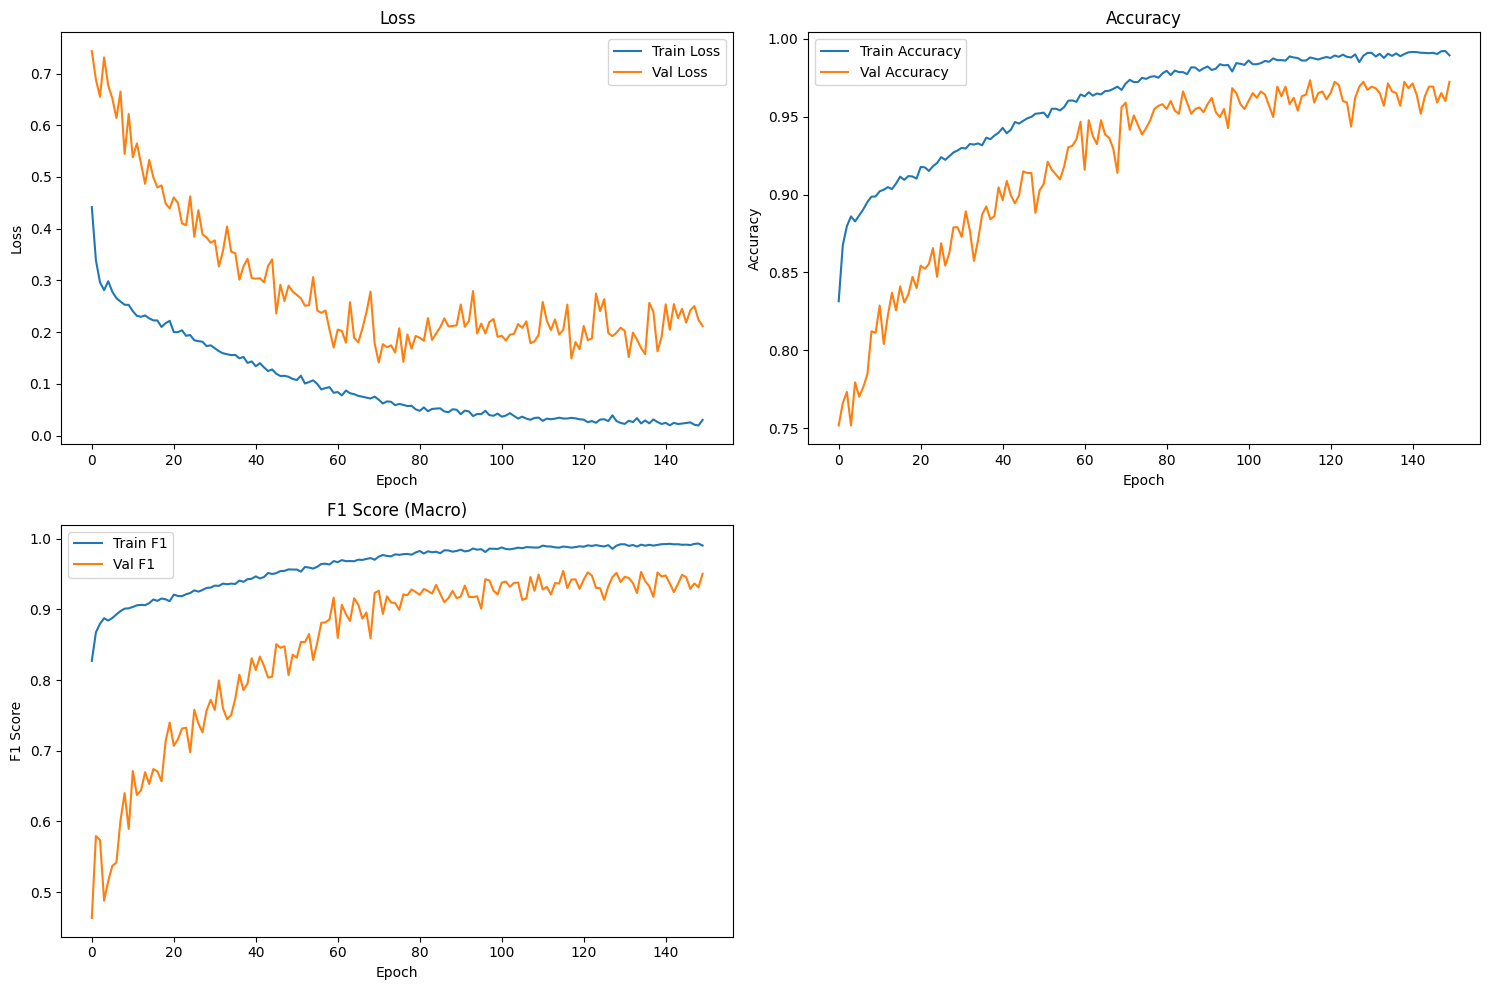

In [11]:
# Plot training history
plt.figure(figsize=(15, 10))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss')
plt.plot(training_history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy')
plt.plot(training_history['val_acc'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation F1 score
plt.subplot(2, 2, 3)
plt.plot(training_history['train_f1'], label='Train F1')
plt.plot(training_history['val_f1'], label='Val F1')
plt.title('F1 Score (Macro)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()


plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_history.png'))
plt.show()

In [12]:
# Cell 8 (Updated): Evaluate the model
# Evaluate on test set
print("\nEvaluating on test set...")
# The evaluate_model function now returns: metrics_dict, confusion_matrix_object, classification_report_string
metrics_dict, confusion_mat, class_report_str = evaluate_model(
    model=model,
    test_loader=data_loaders['test'],
    device=device
)

# Access individual metrics from the dictionary
test_accuracy = metrics_dict['accuracy']
test_f1_score = metrics_dict['f1_macro']    # Or 'f1_weighted' if you prefer
test_precision = metrics_dict['precision_macro'] # Or 'precision_weighted'
test_recall = metrics_dict['recall_macro']    # Or 'recall_weighted'

# Note: Test loss is not calculated or returned by the current evaluate_model function.
# If you need test loss, you'll need to modify evaluate_model to calculate and return it.
# For now, we'll comment out the test_loss print statement or print a placeholder.
# print(f"\nTest Loss: {test_loss:.4f}") # This would cause an error as test_loss is not defined
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# The confusion_mat and class_report_str are now directly available for use in Cell 9


Evaluating on test set...

Evaluation Results:
Accuracy: 0.9723
F1 Score (Macro): 0.9539
F1 Score (Weighted): 0.9721

Per-Class F1 Scores:
  Class 0: 0.9880
  Class 1: 0.9170
  Class 2: 0.9439
  Class 3: 0.9615
  Class 4: 0.9589

Confusion Matrix:
[[657   4   1   0   0]
 [  7 105   3   1   1]
 [  2   3 101   0   1]
 [  1   0   2  50   0]
 [  1   0   0   0  35]]

Test Accuracy: 0.9723
Test F1 Score: 0.9539
Test Precision: 0.9583
Test Recall: 0.9499


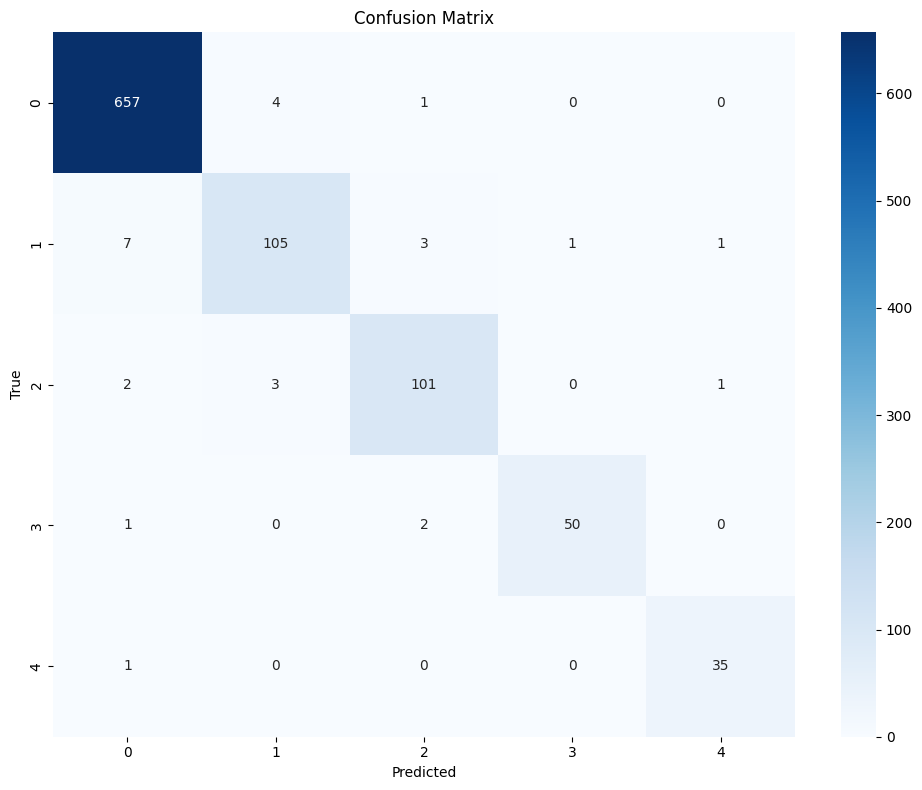


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       662
           1       0.94      0.90      0.92       117
           2       0.94      0.94      0.94       107
           3       0.98      0.94      0.96        53
           4       0.95      0.97      0.96        36

    accuracy                           0.97       975
   macro avg       0.96      0.95      0.95       975
weighted avg       0.97      0.97      0.97       975



In [13]:
# Cell 9 (Updated): Visualize confusion matrix and print classification report
# Plot confusion matrix (confusion_mat is now directly the matrix object)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues') # Use confusion_mat directly
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# Print classification report (class_report_str is now directly the report string)
print("\nClassification Report:")
print(class_report_str) # Use class_report_str directly

In [14]:
# Cell 10: Save the model
# Save the model
torch.save(model.state_dict(), f"{output_dir}/SEResnet_model.pth")
print(f"\nModel saved to {output_dir}/SEResnet_model.pth")


Model saved to results/FINAL_SEResnet_ACGAN_200_20250621_120252/SEResnet_model.pth


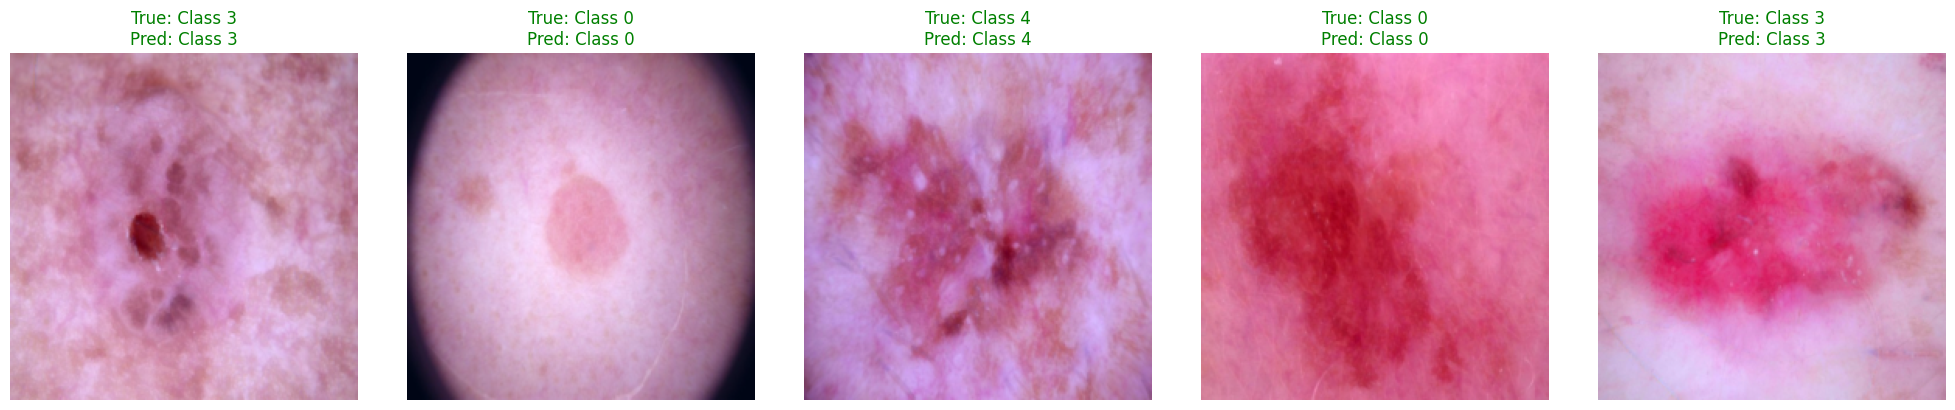

In [15]:
# Cell 11: Optional - Sample prediction visualization
# Visualize some predictions
def visualize_predictions(model, data_loader, device, num_samples=5):
    model.eval()
    # Get class names (assuming they're in order 0,1,2,3,4 for your 5 classes)
    class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

    # Get a batch
    try:
        batch = next(iter(data_loader))
        images = batch['image'] # Access 'image' key from the batch dictionary
        labels = batch['label'] # Access 'label' key from the batch dictionary
    except StopIteration:
        print("Data loader is empty or exhausted.")
        return
    except KeyError:
        print("Batch dictionary does not contain 'image' or 'label' keys. Please check your DataLoader.")
        return

    with torch.no_grad():
        # Ensure we don't try to display more samples than available in the batch
        actual_samples_to_show = min(num_samples, images.size(0))

        for i in range(actual_samples_to_show):
            img_tensor = images[i].unsqueeze(0).to(device) # Prepare image tensor for model
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)

            # Convert tensor to numpy for plotting
            # Move to CPU before converting to numpy
            img_display = images[i].cpu().numpy().transpose((1, 2, 0))

            # Basic normalization for display (scales to 0-1 range)
            # If your dataloader uses specific mean/std normalization,
            # a more accurate de-normalization step would be ideal here.
            img_min = img_display.min()
            img_max = img_display.max()
            if img_max > img_min: # Avoid division by zero if image is flat
                 img_display = (img_display - img_min) / (img_max - img_min)
            else:
                 img_display = img_display - img_min # Just shift to start from 0

            # Clip to [0,1] just in case, for imshow
            img_display = img_display.clip(0, 1)

            axes[i].imshow(img_display)

            true_label_val = labels[i].item()
            predicted_label_val = predicted.item()

            color = 'green' if predicted_label_val == true_label_val else 'red'

            # Ensure labels are within the bounds of class_names
            true_class_str = class_names[true_label_val] if 0 <= true_label_val < len(class_names) else f"Unknown ({true_label_val})"
            pred_class_str = class_names[predicted_label_val] if 0 <= predicted_label_val < len(class_names) else f"Unknown ({predicted_label_val})"

            axes[i].set_title(f"True: {true_class_str}\nPred: {pred_class_str}",
                            color=color)
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/sample_predictions.png")
    plt.show()

# Run visualization
# Ensure data_loaders['test'] is not empty and model is trained
if len(data_loaders['test']) > 0:
    visualize_predictions(model, data_loaders['test'], device)
else:
    print("Test data loader is empty, skipping prediction visualization.")
